# EfficientGlobalOptimization examples

In [1]:
import openturns as ot
import math as m

The EGO algorithm (jones1998) is an adaptative optimization method based on
kriging.

An initial design of experiment is used to build a first metamodel.
At each iteration a new point that maximizes a criterion is chosen as
optimizer candidate.

The criterion uses a tradeoff between the metamodel value and the conditional
variance.

Then the new point is evaluated using the original model and the metamodel is
relearnt on the extended design of experiment.

## E.I. formulation: Ackley test-case

The Ackley test case is a real function defined in dimension $d$ where $d$ is an integer. 

The Ackley function is defined by the equation:

$$
f(\mathbf{x}) = -a \exp\left(-b\sqrt{\frac{1}{d}\sum_{i=1}^d}x_i^2\right)-\exp\left(\frac{1}{d}\sum_{i=1}^d \cos(c x_i)\right)+a+\exp(1)
$$

for any $\mathbf{x} \in [-15,15]^d$.

We use the dimension $d=2$ with the parameters $a=20$, $b=0.2$, $c=2\pi$. 

The solution is 
$$
\mathbf{x}^\star=(0,0,...,0)
$$

where 

$$
f_{min} = f(\mathbf{x}^\star) = 0.
$$

In [2]:
dim = 2

# model
def ackley(X):
    a = 20.0
    b = 0.2
    c = 2.0 * m.pi
    d = len(X)
    f = -a * m.exp(-b*m.sqrt(sum(x**2 for x in X)/d)) \
        - m.exp(sum(m.cos(c*x) for x in X)/d) + a + m.exp(1.0)
    return [f]

model = ot.PythonFunction(dim, 1, ackley)

In [3]:
xexact = [0.0] * dim

In [4]:
fmin = model(xexact)
fmin

class=Point name=Unnamed dimension=1 values=[4.44089e-16]

In [5]:
# problem
problem = ot.OptimizationProblem()
problem.setObjective(model)
bounds = ot.Interval([-15.0] * dim, [15.0] * dim)
problem.setBounds(bounds)

In [6]:
distribution = ot.ComposedDistribution([ot.Uniform(-15.0, 15.0)] * dim)
sampleSize = 50
experiment = ot.LHSExperiment(distribution, sampleSize)
inputSample = experiment.generate()
outputSample = model(inputSample)

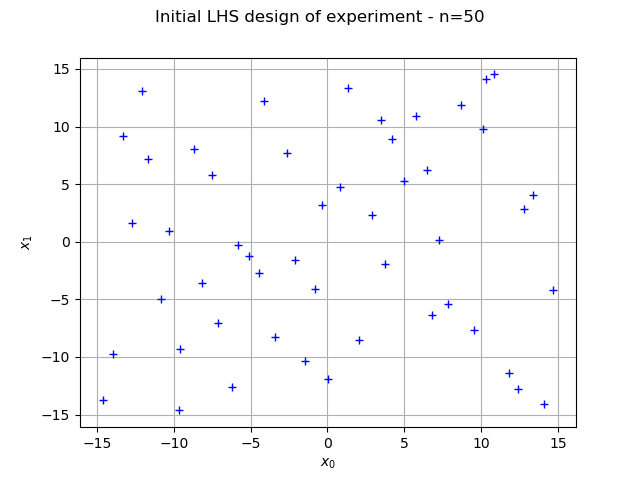

In [7]:
graph = ot.Graph("Initial LHS design of experiment - n=%d" % (sampleSize), "$x_0$", "$x_1$", True)
cloud = ot.Cloud(inputSample)
graph.add(cloud)
graph

In [8]:
# first kriging model
covarianceModel = ot.SquaredExponential([1.0] * dim, [0.1])
basis = ot.ConstantBasisFactory(dim).build()
kriging = ot.KrigingAlgorithm(inputSample, outputSample, covarianceModel, basis)
kriging.run()

In [9]:
# algo
algo = ot.EfficientGlobalOptimization(problem, kriging.getResult())
algo.setMaximumEvaluationNumber(10)
algo.setMaximumAbsoluteError(1e-3)
algo.setMaximumRelativeError(1e-3)
algo.setMaximumResidualError(1e-3)
algo.setMaximumConstraintError(1e-3)
algo.setMultiStartExperimentSize(50) # number of multistart candidates improvement optim
algo.setMultiStartNumber(10) # number of multistart points for improvement optim
algo.setParameterEstimationPeriod(2) # relearn kriging parameters every X iteration
algo.setImprovementFactor(1.0) # improvement stopping criterion factor
algo.setCorrelationLengthFactor(1.0) # correlation length stopping criterion factor
algo.run()
result = algo.getResult()

In [10]:
result.getIterationNumber()

1

In [11]:
result.getOptimalPoint()

class=Point name=Unnamed dimension=2 values=[-0.301221,-1.36751]

In [12]:
result.getOptimalValue()

class=Point name=Unnamed dimension=1 values=[5.70164]

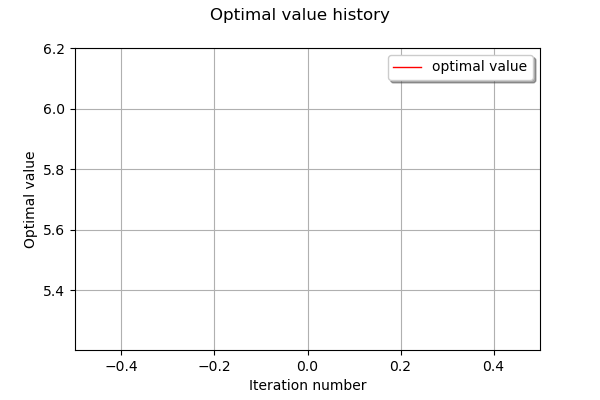

In [13]:
result.drawOptimalValueHistory()

In [14]:
# local refinement
algo2 = ot.NLopt(problem, 'LD_LBFGS')
algo2.setStartingPoint(result.getOptimalPoint())
algo2.run()
result = algo2.getResult()

In [15]:
result.getOptimalPoint()

class=Point name=Unnamed dimension=2 values=[0.952166,-1.40133e-05]

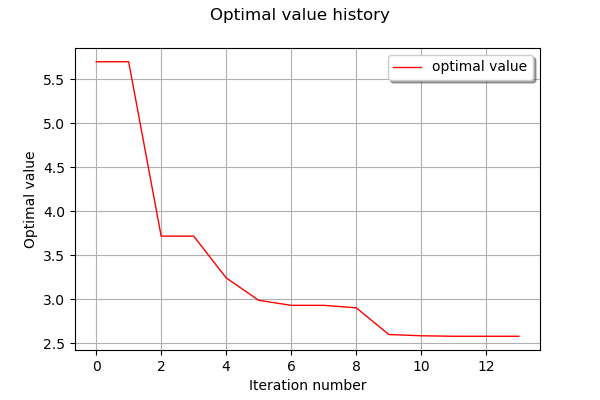

In [16]:
result.drawOptimalValueHistory()

## AIE formulation: Branin test-case

The Branin function is defined in 2 dimensions based on the functions $g$:

$$ 
g(u_1, u_2) = \frac{\left(u_2-5.1\frac{u_1^2}{4\pi^2}+5\frac{u_1}{\pi}-6\right)^2+10\left(1-\frac{1}{8 \pi}\right)  \cos(u_1)+10-54.8104}{51.9496}
$$

and $t$:

$$ 
t(x_1, x2) = (15 x_1 - 5, 15 x_2)^T.
$$

Finally, the Branin function is the composition of the two previous functions:

$$
f(x_1, x_2) = g \circ  t(x_1, x_2)
$$

for any $\mathbf{x} \in [0, 1]^2$. 

There are three global minimas:

$$
\mathbf{x}^\star=(0.123895, 0.818329),
$$

$$
\mathbf{x}^\star=(0.542773, 0.151666),
$$

and :

$$
\mathbf{x}^\star=(0.961652, 0.165000)
$$

where the function value is:

$$
f_{min} = f(\mathbf{x}^\star) = -1.04741.
$$


This time the AEI formulation is used, the objective output should be 2-d with the noise variance.

Here we assume a constant noise variance: $$\sigma_{\epsilon} = 0.96$$

In [17]:
dim = 2

# model
branin = ot.SymbolicFunction(['x1', 'x2'], 
                             ['((x2-(5.1/(4*pi_^2))*x1^2+5*x1/pi_-6)^2+10*(1-1/8*pi_)*cos(x1)+10-54.8104)/51.9496', '0.96'])
transfo = ot.SymbolicFunction(['u1', 'u2'], 
                              ['15*u1-5', '15*u2'])
model = ot.ComposedFunction(branin, transfo)

In [18]:
# problem
problem = ot.OptimizationProblem()
problem.setObjective(model)
bounds = ot.Interval([0.0] * dim, [1.0] * dim)
problem.setBounds(bounds)

In [19]:
distribution = ot.ComposedDistribution([ot.Uniform(0.0, 1.0)] * dim)
sampleSize = 50
experiment = ot.LHSExperiment(distribution, sampleSize)
inputSample = experiment.generate()
modelEval = model(inputSample)
outputSample = modelEval.getMarginal(0)

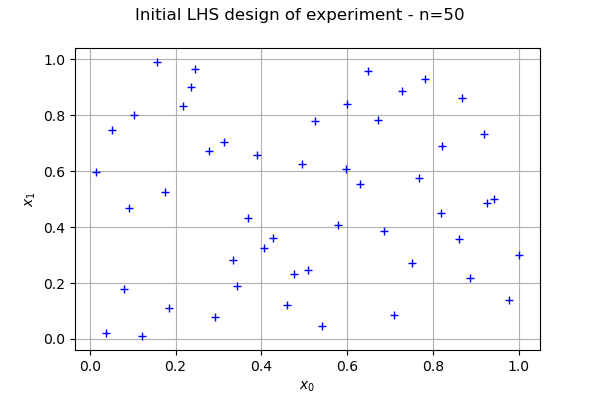

In [20]:
graph = ot.Graph("Initial LHS design of experiment - n=%d" % (sampleSize), "$x_0$", "$x_1$", True)
cloud = ot.Cloud(inputSample)
graph.add(cloud)
graph

In [21]:
# first kriging model
covarianceModel = ot.SquaredExponential([0.3007, 0.2483], [0.981959])
basis = ot.ConstantBasisFactory(dim).build()
kriging = ot.KrigingAlgorithm(inputSample, outputSample, covarianceModel, basis)
noise = [x[1] for x in modelEval]
kriging.setNoise(noise)
kriging.run()

In [22]:
# algo
algo = ot.EfficientGlobalOptimization(problem, kriging.getResult())
algo.setNoiseModel(ot.SymbolicFunction(['x1', 'x2'], ['0.96'])) # assume constant noise var
algo.setMaximumEvaluationNumber(5)
algo.setImprovementFactor(0.05) # stop whe improvement is < a% the current optimum
algo.setAEITradeoff(0.66744898)
algo.run()
result = algo.getResult()
print('iteration=', result.getIterationNumber())

iteration= 1


In [23]:
result.getOptimalPoint()

class=Point name=Unnamed dimension=2 values=[0.977987,0.140975]

In [24]:
result.getOptimalValue()

class=Point name=Unnamed dimension=1 values=[-0.969625]

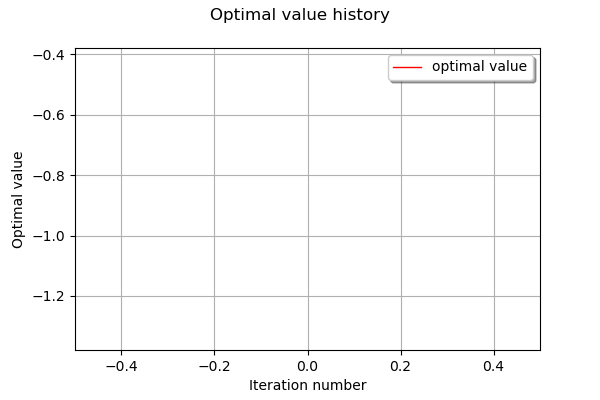

In [25]:
result.drawOptimalValueHistory()